In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
from speech_dataset import *
from models import ConvBiLSTM

In [4]:
train_dataset, test_dataset = load_torch_dataset()

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [25]:
model = ConvBiLSTM()

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

In [35]:
losses = []

In [44]:
model.train()

for i in range(25):
    epoch_loss = 0
    b = 0

    for X, Y in train_dataloader:
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds.view(-1, 2), Y.view(-1))

        if b % 5 == 0:
            print(f"b={b+1:02d}: {loss.item()}")
    
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        b += 1

    epoch_loss = epoch_loss / len(train_dataset)
    losses.append(epoch_loss)

    print(f"==== Epoch {i+1}: train_loss={epoch_loss:.10f}")

print("Done")

b=01: 0.6684656143188477
b=06: 0.6539021730422974
b=11: 0.7564419507980347
==== Epoch 1: train_loss=0.0232130741
b=01: 0.6661630272865295
b=06: 0.6489089131355286
b=11: 0.7553314566612244
==== Epoch 2: train_loss=0.0231653778
b=01: 0.6659603714942932
b=06: 0.653792679309845
b=11: 0.7561290264129639
==== Epoch 3: train_loss=0.0231860848
b=01: 0.6712004542350769
b=06: 0.6525869965553284
b=11: 0.754222571849823
==== Epoch 4: train_loss=0.0232164703
b=01: 0.6679230332374573
b=06: 0.6547988057136536
b=11: 0.754538357257843
==== Epoch 5: train_loss=0.0231784314
b=01: 0.6679486036300659
b=06: 0.6491699814796448
b=11: 0.7596842050552368
==== Epoch 6: train_loss=0.0231873356
b=01: 0.6661430597305298
b=06: 0.6529382467269897
b=11: 0.7563042044639587
==== Epoch 7: train_loss=0.0231371497
b=01: 0.6710732579231262
b=06: 0.6555019021034241
b=11: 0.75881427526474
==== Epoch 8: train_loss=0.0232362665
b=01: 0.6636104583740234
b=06: 0.6504364609718323
b=11: 0.7542726993560791
==== Epoch 9: train_loss=0

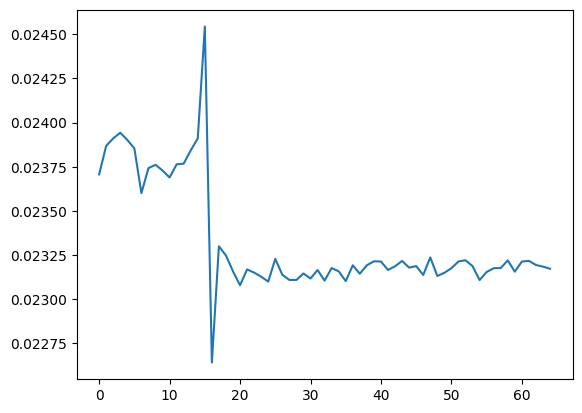

In [45]:
plt.plot(losses)

In [43]:
# torch.save({'model_state': model.state_dict()},'checkpoints/model_001.chk')

In [ ]:
# checkpoint = torch.load('checkpoints/model1_003.chk')
# model.load_state_dict(checkpoint['model_state'])